In [ ]:
# default_exp funcs.merfish_eval

In [ ]:
%load_ext autoreload
%autoreload 2

# MERFISH routines

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import pprint

In [ ]:
bench = pd.read_csv(
    io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
    dtype={'barcode': object})

#See Fig. S4 https://www.pnas.org/content/113/39/11046

bench_df = bench.copy()
bench_df = bench_df[bench_df['total_magnitude']>10**0.75 * 4]
bench_df = bench_df[bench_df['area']>3]

print(len(bench_df))

experiment = data.MERFISH(use_test_data=True)
code_ref = experiment.codebook.data.reshape([140,-1], order='F')
targets = experiment.codebook.indexes['target']

13832


In [ ]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_c_02noise.csv')
pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
len(pred_df)

283544

In [ ]:
# from decode_fish.funcs.routines import filt_perc
# pred_df = filt_perc(pred_df, 50, return_low=True, metric='comb_sig')

In [ ]:
# pred_df0 = pd.read_csv('../data/results/MERFISH/exp_3_ch0.csv')
# pred_df1 = pd.read_csv('../data/results/MERFISH/exp_3_ch1.csv')
# pred_df1['frame_idx'] += 8
# pred_df1['loc_idx'] += pred_df0['loc_idx'].values[-1] + 1
# pred_df = pred_df0.append(pred_df1)
# pred_df = pred_df.reset_index(drop=True)
# pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
# len(pred_df)

100%|██████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 264.96it/s]


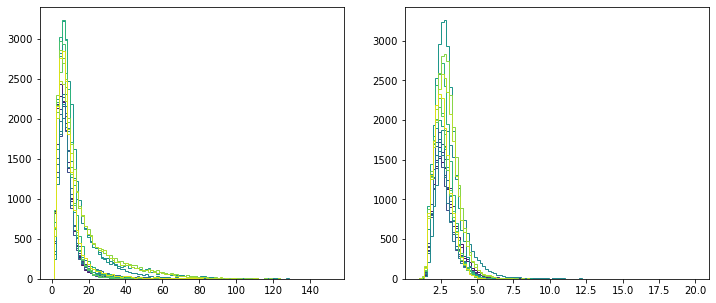

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
cmap = sns.color_palette("viridis", n_colors=16)

for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['comb_sig'], histtype='step', bins=np.linspace(1,151,101),color=cmap[i])
plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['int'], histtype='step', color=cmap[i], bins=np.linspace(1,20,101))


In [ ]:
#export
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]
    return None

def get_bin_code(frame_idx, n_imgs=16):
    code = np.zeros(n_imgs, dtype='int8')
    code[frame_idx] = 1
    return code

def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids

In [ ]:
#export
def code_from_groups(loc_df):
    
    loc_df = loc_df[loc_df['group_idx'] > 0]
    loc_df = loc_df.sort_values('group_idx').reset_index(drop=True)
    group_idx = loc_df['group_idx'].values
    group_idx = np.array(group_idx, dtype=np.uint32)

    inds = np.where(np.diff(group_idx))[0] + 1
    
    xy = loc_df.loc[:,['x','y']].values
    xy_sig = loc_df.loc[:,['x_sig','y_sig']].values
    ints = loc_df.loc[:,'int'].values
    frame_idx = loc_df.loc[:,'frame_idx'].values
    
    codes, rmses, cc, intsum, logs = [], [], [], [], []
    
    for i in tqdm(range(len(inds)-1)):
        
        sl = np.s_[inds[i]:inds[i+1]]
        
        code = get_bin_code(frame_idx[sl])
        codes.append(code)
        cc.append(code.sum())
        
        rmses.append(np.sqrt(np.mean((xy[sl] - xy[sl].mean(0))**2)))
        intsum.append(ints[sl].sum())

        log_dists = torch.distributions.normal.Normal(T([0,0]), torch.sqrt(T(xy_sig[sl][None])**2 + T(xy_sig[sl][:,None])**2)). \
                                             log_prob(T(xy[sl][None]) - T(xy[sl][:,None])).sum(-1)
        
        log_dists = torch.triu(log_dists, diagonal=1)
        logs.append(log_dists.sum()/torch.count_nonzero(log_dists))

    res_df = loc_df.iloc[inds[:-1]].copy()
    res_df['code'] = codes
    res_df['cc'] = cc
    res_df['rmses'] = rmses
    res_df['int'] = intsum
    res_df['logdist'] = np.array(logs)
    
    return res_df

In [ ]:
# export
def get_bin_code_crossframe(pred_df, group_rad=150):

    loc_df=pred_df.copy()
    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = -1

    group_count = 0

    for i in tqdm(range(0, N_imgs-1)):

        i_inds = (loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)
        i_df = loc_df[(loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
        loc_df.loc[i_inds,'group_idx'] = np.arange(len(i_df)) + group_count
        i_df.loc[:,'group_idx'] = np.arange(len(i_df)) + group_count
        group_count += len(i_df)

        tree = cKDTree(i_df.loc[:,['x','y']].values)

        for k in range(i+1, N_imgs):

            k_df = loc_df[(loc_df['frame_idx'] == k) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
            dists, inds = tree.query(k_df.loc[:,['x','y']].values, distance_upper_bound=group_rad) 

            i_inds, k_inds = np.unique(inds, return_index=True)
            k_inds = list(k_inds[:-1])
            i_inds = list(i_inds[:-1])

            loc_inds = k_df['loc_idx'].values[k_inds]
            loc_df.loc[loc_inds,'group_idx'] = i_df.loc[i_inds,'group_idx'].values

    res_df = code_from_groups(loc_df)
    
    return res_df

In [ ]:
# res_df_crossframe = get_bin_code_crossframe(pred_df, 150)

In [ ]:
# export
def get_bin_code_frameiter(pred_df, group_rad=150, n_nearest=15):

    loc_df=pred_df.copy()

    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = -1
    loc_df['group_logs'] = 0
    print(len(loc_df))

    group_count = 0

    for i in tqdm(range(0, N_imgs)):

        i_inds = (loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)
        i_df = loc_df[(loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
        i_df.loc[:,'group_idx'] = np.arange(len(i_df)) + group_count
        loc_df.loc[i_inds,'group_idx'] = np.arange(len(i_df)) + group_count
        group_count += len(i_df)

        k_df = loc_df[(loc_df['frame_idx'] > i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)

        tree = cKDTree(k_df.loc[:,['x','y']].values)
        dists, inds = tree.query(i_df.loc[:,['x','y']].values, k = n_nearest, distance_upper_bound=group_rad) 

        for n in range(n_nearest):

            k_inds, i_inds = np.unique(inds[:, n], return_index=True)
            k_inds = list(k_inds[:-1])
            i_inds = list(i_inds[:-1])


            loc_inds = k_df['loc_idx'].values[k_inds]
            loc_df.loc[loc_inds,'group_idx'] = i_df.loc[i_inds,'group_idx'].values

    return loc_df

In [ ]:
loc_df = get_bin_code_frameiter(pred_df, group_rad=150, n_nearest=15)

  0%|                                                                        | 0/16 [00:00<?, ?it/s]

283544


100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.70it/s]


In [ ]:
# export
import torch.tensor as T
def get_bin_code_logorder(pred_df, group_rad=150, log_lim=-500):
    
    loc_df=pred_df.copy().reset_index(drop=True)
    
    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = 0

    tree1 = cKDTree(loc_df.loc[:,['x','y']].values)
    tree2 = cKDTree(loc_df.loc[:,['x','y']].values)

    sdm = tree1.sparse_distance_matrix(tree2, group_rad, output_type='ndarray')

    frame_filt = loc_df['frame_idx'].values[sdm['i']] != loc_df['frame_idx'].values[sdm['j']]

    dists = sdm['v'][frame_filt]
    k_inds = sdm['i'][frame_filt]
    i_inds = sdm['j'][frame_filt]

    log_dists = torch.distributions.normal.Normal(T([0,0]), torch.sqrt(T(loc_df.loc[i_inds,['x_sig','y_sig']].values)**2 +
                                                                       T(loc_df.loc[k_inds,['x_sig','y_sig']].values)**2)). \
                                                                       log_prob(T(loc_df.loc[k_inds,['x','y']].values) - T(loc_df.loc[i_inds,['x','y']].values))

    log_dists = log_dists.sum(-1)
    inds = np.argsort(log_dists).flip(0)
    # Every entry is double because the pointclouds are the same. 
    log_dists, k_inds, i_inds = [s[inds][::2] for s in [log_dists, k_inds, i_inds]]

    if log_lim:
        inds = log_dists > log_lim
        log_dists, k_inds, i_inds = [s[inds] for s in [log_dists, k_inds, i_inds]]

#     return group_idx, log_dists, k_inds, i_inds
#     group_idx = log_loop(np.array(group_idx), np.array(log_dists), np.array(k_inds), np.array(i_inds))
    
    group_count = 1
    # Operate on array for much faster calculations
    group_idx = np.array(loc_df['group_idx'].values, dtype=np.uint32)

    for d, k, i in tqdm(zip(np.array(log_dists), np.array(k_inds, dtype=np.uint32), np.array(i_inds, dtype=np.uint32))):
        
        i_gidx = group_idx[i]
        k_gidx = group_idx[k]
        
        sum_gidx = i_gidx + k_gidx
        
        if not sum_gidx:
            # Both not grouped, create new group
            group_idx[i] = group_count
            group_idx[k] = group_count
            group_count += 1     
        else:
            if not k_gidx:
                # k not grouped, i grouped. Assign k to i group
                if np.count_nonzero(group_idx == i_gidx) < 4:
                    group_idx[k] = i_gidx  
            elif not i_gidx:
                # i not grouped, k grouped. Assign i to k group
                if np.count_nonzero(group_idx == k_gidx) < 4:
                    group_idx[i] = k_gidx   
            else:
                if k_gidx != i_gidx:
                    # Both grouped in different groups. Connect if len <= 5
                    if np.count_nonzero(group_idx == k_gidx) + np.count_nonzero(group_idx == i_gidx) <= 5:
                        group_idx[group_idx == k_gidx] = i_gidx  

    loc_df['group_idx'] = group_idx
    return loc_df

In [ ]:
loc_df_logorder = get_bin_code_logorder(pred_df, group_rad=150, log_lim=None)

1367260it [02:23, 9521.98it/s]


In [ ]:
# #export
# def get_bin_code(frame_idx, probs, n_imgs=16):
#     probs = probs * (1 - torch.eye(len(probs), len(probs)))
#     code = np.zeros(n_imgs)
#     code[frame_idx] = probs.mean(0)
#     return code

# def code_from_groups(loc_df):
    
#     loc_df = loc_df[loc_df['group_idx'] > 0]
#     loc_df = loc_df.sort_values('group_idx').reset_index(drop=True)
#     group_idx = loc_df['group_idx'].values
#     group_idx = np.array(group_idx, dtype=np.uint32)

#     inds = np.where(np.diff(group_idx))[0] + 1
    
#     xy = loc_df.loc[:,['x','y']].values
#     xy_sig = loc_df.loc[:,['x_sig','y_sig']].values
#     ints = loc_df.loc[:,'int'].values
#     frame_idx = loc_df.loc[:,'frame_idx'].values
    
#     codes, rmses, cc, intsum, logs = [], [], [], [], []
    
#     for i in tqdm(range(len(inds)-1)):
        
#         sl = np.s_[inds[i]:inds[i+1]]
#         cc.append(len(frame_idx[sl]))
        
#         rmses.append(np.sqrt(np.mean((xy[sl] - xy[sl].mean(0))**2)))
#         intsum.append(ints[sl].sum())

#         log_dists = torch.distributions.normal.Normal(T([0,0]), torch.sqrt(T(xy_sig[sl][None])**2 + T(xy_sig[sl][:,None])**2)). \
#                                              log_prob(T(xy[sl][None]) - T(xy[sl][:,None])).sum(-1)
        
#         code = get_bin_code(frame_idx[sl], torch.exp(log_dists))
#         codes.append(code)
        
#         log_dists = torch.triu(log_dists, diagonal=1)
#         logs.append(log_dists.sum()/torch.count_nonzero(log_dists))
        

#     res_df = loc_df.iloc[inds[:-1]].copy()
#     res_df['code'] = codes
#     res_df['cc'] = cc
#     res_df['rmses'] = rmses
#     res_df['int'] = intsum
#     res_df['logdist'] = np.array(logs)
    
#     return res_df

In [ ]:
res_df_logorder = code_from_groups(loc_df)

100%|███████████████████████████████████████████████████████| 84016/84016 [00:37<00:00, 2245.10it/s]


In [ ]:
res_df = res_df_logorder

In [ ]:
# # # Save as csv
# res_df.to_pickle('../data/results/MERFISH/exp_02met.pickle')
# # # Load from csv
# # res_df = pd.read_pickle('../data/results/MERFISH/exp_02met.pickle')

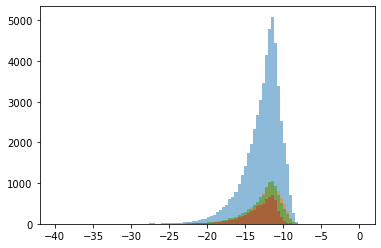

In [ ]:
_ = plt.hist(res_df['logdist'].values, bins=np.linspace(-40,0,101), alpha=0.5)
_ = plt.hist(res_df[res_df['cc']==3]['logdist'].values, bins=np.linspace(-40,0,101), alpha=0.5)
_ = plt.hist(res_df[res_df['cc']==4]['logdist'].values, bins=np.linspace(-40,0,101), alpha=0.5)
_ = plt.hist(res_df[res_df['cc']==5]['logdist'].values, bins=np.linspace(-40,0,101), alpha=0.5)

84016 38285


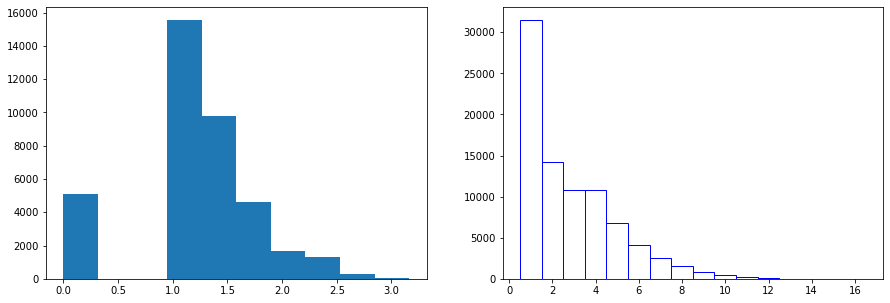

38285 20659
0.24710779805411684
5105


In [ ]:
code_all = np.stack(res_df['code'])
cond = (res_df['cc'] > 2)
res_df_filt = res_df[cond]
code_l = code_all[cond]
code_l = code_l/code_l.max()

print(len(res_df), len(res_df_filt))

# metric_outputs, pred_targets = approximate_nearest_code(norm_features(code_ref), norm_features(code_l), targets)
metric_outputs, pred_targets = approximate_nearest_code(code_ref, code_l, targets)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(metric_outputs)
plt.subplot(122)
plt.hist(res_df['cc'].values, bins=np.linspace(0.5,16.5,17), facecolor='None', edgecolor='blue')
plt.show()

preds_filt = pred_targets[metric_outputs <= 1.25]
print(len(pred_targets), len(preds_filt))

print(sum(metric_outputs==0)/len(preds_filt))

res_df_filt = res_df_filt[metric_outputs <= 1.25]
res_df_filt['gene'] = preds_filt
print(sum(metric_outputs==0))
res_df_filt['code_err'] = metric_outputs[metric_outputs <= 1.25]

In [ ]:
bench_match = bench_df.copy()
bench_match.loc[:,'frame_idx'] = 0
bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
bench_match.loc[:,'int'] = bench_match['total_magnitude']
bench_match.loc[:,'z'] = 50/100
bench_match = px_to_nm(bench_match)

res_df_filt.loc[:,'frame_idx'] = 0

_,_,shift = matching(bench_match, res_df_filt, tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))

_,_,shift = matching(bench_match, res_df_filt, tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))
_,matches,shift = matching(bench_match, res_df_filt, tolerance=250, print_res=True)

Recall: 0.646
Precision: 0.433
Jaccard: 34.999
RMSE_vol: 108.162
Eff_3d: 15.443
FN: 4890.0 FP: 11717.0
Num. matches: 8942.000
Shift: 4.97,4.69,0.00


In [ ]:
res_df_filt

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig,group_idx,group_logs,code,cc,rmses,logdist,gene,code_err
32253,22550,0,76648.430,104661.950,50.0,0.957901,16.557921,0.697336,22.675608,24.425474,100.0,5.40771,5806,0,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",4,86.703652,-25.577484,PRKDC,0.0
137807,164251,0,69722.200,22705.068,50.0,1.000000,14.090303,0.363766,24.561007,22.320456,100.0,5.36340,24791,0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]",4,52.270376,-17.935594,THBS1,0.0
148582,39758,0,79310.620,112738.160,50.0,0.919823,16.247253,0.311205,14.013383,14.857771,100.0,2.06434,27120,0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]",4,32.130902,-11.828324,THBS1,0.0
174272,249934,0,37645.086,87709.945,50.0,0.539975,9.199337,0.324554,44.299180,36.130875,100.0,15.18619,32790,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]",4,52.283102,-13.773756,ZNF592,0.0
237143,264385,0,25824.137,172826.770,50.0,1.000000,23.611619,0.660762,51.774746,42.592773,100.0,20.39422,50527,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]",4,52.284261,-11.435240,MALAT1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30482,6317,0,19476.344,101845.695,50.0,0.733489,11.265479,0.471409,30.744967,26.628483,100.0,7.95522,5513,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",3,36.237879,-11.550569,FASN,1.0
208105,223922,0,40936.727,9012.472,50.0,1.000000,9.244060,0.886633,32.722015,31.689724,100.0,9.88616,41177,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",3,36.242728,-11.484661,MCF2L,1.0
136102,182355,0,88393.375,11706.277,50.0,1.000000,8.366844,0.773402,34.968906,30.339073,100.0,10.19657,24418,0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",3,36.245662,-11.459319,THBS1,1.0
183270,236785,0,10578.637,159279.060,50.0,0.882073,7.730337,0.276381,26.636553,24.244066,100.0,6.28867,34851,0,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]",3,36.207965,-11.980185,RAB3B,1.0


In [ ]:
x = np.linspace(1000,len(res_df_filt),100)
max_blanks = res_df_filt['gene'].str.contains('Blank').sum()
vardict = {'logdist':False, 'int':False, 'rmses':True, 'code_err':True}
rocs = {}

for v in vardict:
    
    res_df_filt = res_df_filt.sort_values(v, ascending=vardict[v])
    n_blanks = []
    for i in x:
        n_blanks.append((res_df_filt[:int(i)]['gene'].str.contains('Blank')).sum())
    rocs[v] = n_blanks

In [ ]:
xb = np.linspace(1000,len(bench_df),100)
max_blanks_b = bench_df['gene'].str.contains('Blank').sum()
vardict = {'total_magnitude':False, 'av_distance':True}
rocs_b = {}

for v in vardict:
    
    bench_df = bench_df.sort_values(v, ascending=vardict[v])
    n_blanks = []
    for i in xb:
        n_blanks.append((bench_df[:int(i)]['gene'].str.contains('Blank')).sum())
    rocs_b[v] = n_blanks

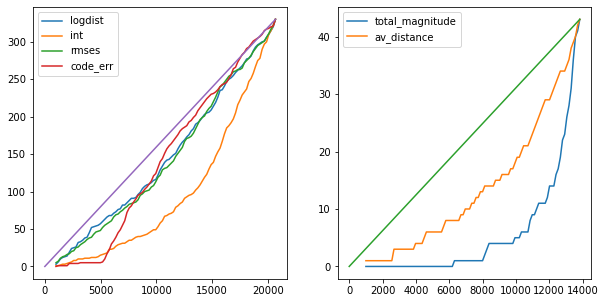

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
for v in rocs:
    plt.plot(x, rocs[v], label=v)
plt.plot([0,len(res_df_filt)],[0,max_blanks])
plt.legend()
plt.subplot(122)
for v in rocs_b:
    plt.plot(xb, rocs_b[v], label=v)
plt.plot([0,len(bench_df)],[0,max_blanks_b])
plt.legend()

In [ ]:
res_sub = res_df_filt[:]

In [ ]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)

fps = res_sub.loc[~res_sub['loc_idx'].isin(matches['pred_idx'])]
fns = bench_match.loc[~bench_match['loc_idx'].isin(matches['tar_idx'])]

bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
bench_counts=bench_counts.fillna(0)

In [ ]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = np.sum(res_counts)
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel('Gene copy number Benchmark')
    plt.ylabel('Gene copy number DECODE')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

13832 48777


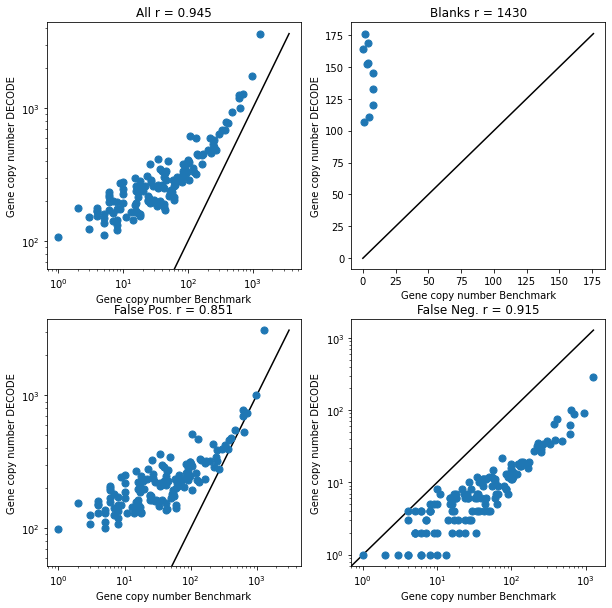

In [ ]:
print(len(bench_df), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

In [ ]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

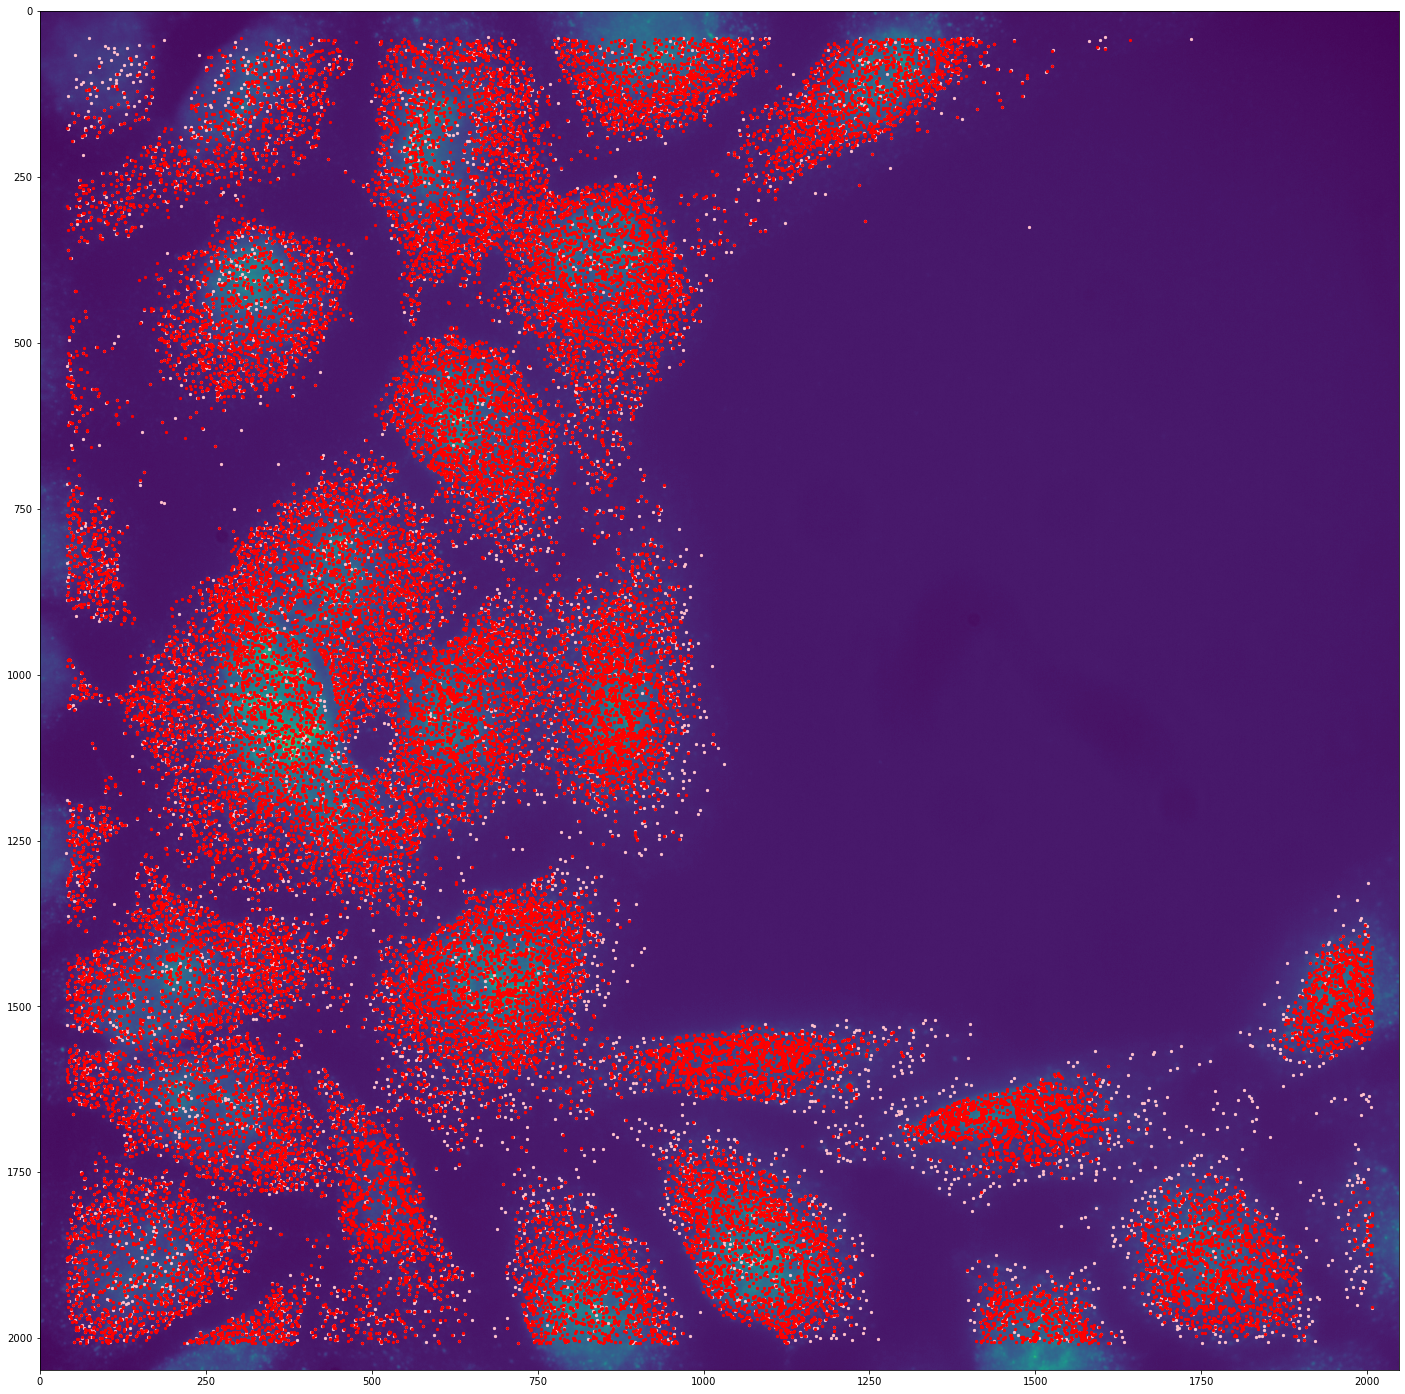

In [ ]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)#[res_sub['gene']=='MALAT1']
bench_px = nm_to_px(bench_match)#[bench_match['gene']=='MALAT1']
plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=5)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=5)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.
